In [6]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
from cmcrameri import cm as cmc

from utils import load_config, default_params, axes_styling, calculate_bathymetry, \
    integrated_contour_momentum_terms, depth_following_contour, get_contour_following_velocities, \
        hnorm_on_xygrid, windforcing


In [7]:
config = "slope-001"

ds = xr.open_dataset("../output/"+config+".nc").squeeze()
params = load_config("../configs/"+config+".json", default_params)
ds

<xarray.Dataset>
Dimensions:       (xC: 120, yF: 90, xF: 121, yC: 90, time: 1025)
Coordinates:
    zC            float64 0.0
    zF            float64 0.0
  * xC            (xC) float64 500.0 1.5e+03 2.5e+03 ... 1.185e+05 1.195e+05
  * yF            (yF) float64 0.0 1e+03 2e+03 3e+03 ... 8.7e+04 8.8e+04 8.9e+04
  * xF            (xF) float64 0.0 1e+03 2e+03 ... 1.18e+05 1.19e+05 1.2e+05
  * yC            (yC) float64 500.0 1.5e+03 2.5e+03 ... 8.85e+04 8.95e+04
  * time          (time) timedelta64[ns] 0 days 00:00:00 ... 128 days 00:00:00
Data variables:
    v             (time, yF, xC) float64 ...
    omegav        (time, yF, xF) float64 ...
    duvhdx        (time, yC, xC) float64 ...
    omega         (time, yF, xF) float64 ...
    omegau        (time, yF, xF) float64 ...
    divomegaflux  (time, yF, xC) float64 ...
    u             (time, yC, xF) float64 ...
    h             (time, yC, xC) float64 ...
    detady        (time, yF, xC) float64 ...
Attributes:
    time averaging stride:  Output was time averaged with a stride of 1 itera...
    interval:               10800.0
    time_averaging_window:  10800.0
    time_averaging_stride:  1
    Oceananigans:           This file was generated using Oceananigans v0.91.14
    Julia:                  This file was generated using Julia Version 1.9.4...
    output time interval:   Output was saved every 3 hours.
    date:                   This file was generated on 2025-03-17T15:36:42.328.
    time averaging window:  Output was time averaged with a window size of 3 ...
    schedule:               TimeInterval

In [8]:
DB = params["DB"]
DS = params["DS"]

H = DB + 0.5*DS

terms = integrated_contour_momentum_terms(params, ds, H)
contour = depth_following_contour(params, H)
Ut, Vt =  get_contour_following_velocities(contour, ds)
cL = contour.dl.sum(dim=("j")).values


terms

<xarray.Dataset>
Dimensions:       (time: 1025)
Coordinates:
    zC            float64 0.0
    zF            float64 0.0
  * time          (time) timedelta64[ns] 0 days 00:00:00 ... 128 days 00:00:00
Data variables:
    surfstress    (time) float64 8.088e-06 2.396e-05 ... -8.091e-06 8.088e-06
    nonlin        (time) float64 -0.0 -4.317e-11 ... -7.443e-07 -4.358e-07
    bottomstress  (time) float64 -0.0 -2.875e-08 ... 4.603e-06 4.733e-06

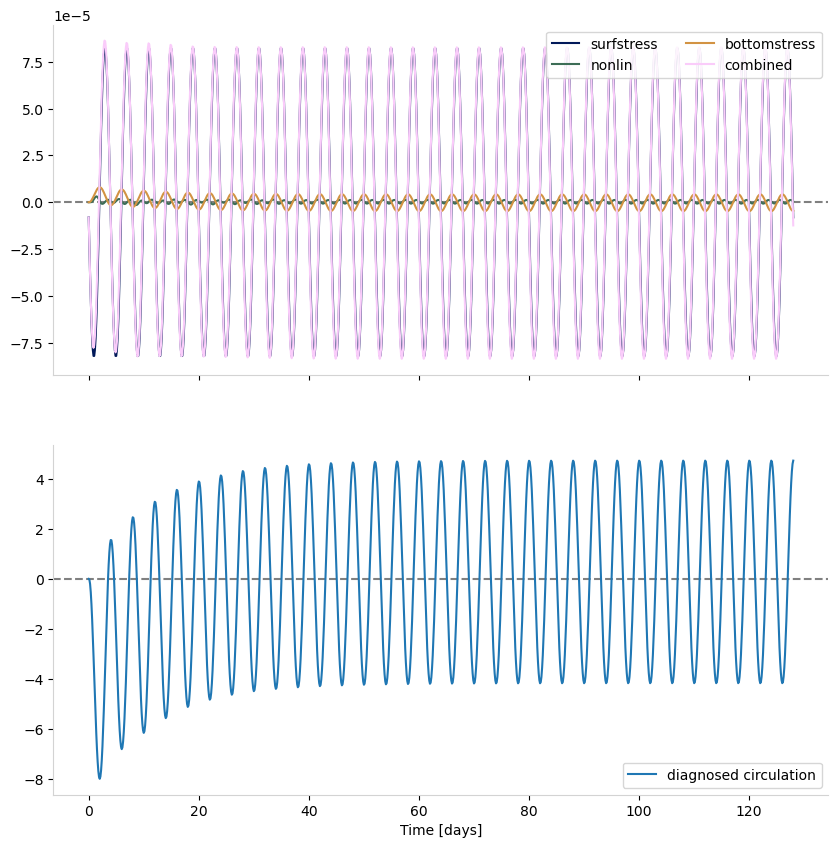

In [9]:
fig, [ax, ax2] = plt.subplots(figsize=(10,10), nrows=2, sharex=True)
axes_styling(ax)
axes_styling(ax2)
ax.axhline(0, color="gray", ls="--")
ax2.axhline(0, color="gray", ls="--")

terms["combined"] = terms["surfstress"] + terms["nonlin"] + terms["bottomstress"]

tday = terms.time / np.timedelta64(1,"D")

colors = cmc.batlow(np.linspace(0, 1, len(terms)))
for term, color in zip(terms, colors):
    ax.plot(tday, -terms[term], label=term, color=color)
    
circ_est = (terms.combined*params["outputtime"]).cumsum("time")
numerical = -(Vt*contour.dl).sum(dim=("j"))*H/cL 
#circ_diag = (ds.v.isel(xC=xidx)*calculate_bathymetry(ds.xC.isel(xC=xidx), ds.yF, params)).mean("yF")


#ax2.plot(tday, -circ_est, label = "estimated circulation")
ax2.plot(tday, numerical, label = "diagnosed circulation")

    
ax.legend(ncols=2)
ax2.legend()

ax2.set_xlabel("Time [days]")

#ax2.set_xlim(50,60)
fig.savefig(f"../figures/terms/Hcontour/Hcontour_terms_ts_{config}.png")

In [10]:
#Hs = np.linspace(DB+1, DB+DS-1, 40)
idxs = np.arange(15, 75)

termlist = []
circlist = []
Hs = []
for idx in idxs:
    H = ds.h.isel(time=1,xC=idx).mean("yC").values
    terms = integrated_contour_momentum_terms(params, ds, H).squeeze()
    
    contour = depth_following_contour(params, H)
    Ut, Vt =  get_contour_following_velocities(contour, ds)
    cL = contour.dl.sum(dim=("j")).values
    numerical = -(Vt*contour.dl).sum(dim=("j"))*H/cL 
    
    termlist.append(terms)
    circlist.append(numerical)
    Hs.append(H)
    
results = xr.concat(termlist, dim="H")
circ = xr.concat(circlist, dim="H")

In [ ]:
# fig, ax = plt.subplots(figsize=(10,10))


# ax.set_aspect("equal")
# ax.pcolormesh(hnorm.xC, hnorm.yC, ds.h.isel(time=1).values)
# step = 4
# ax.quiver(hnorm.xC[::step], hnorm.yC[::step], -hnorm.dhdy[::step,::step], hnorm.dhdx[::step,::step])

: 

: 

: 

: 

In [11]:
u = ds.u.values
v = ds.v.values
omega = ds.omega.values
tau = windforcing(ds.time.values, params)
h = ds.h.isel(time=1).squeeze().values[:,15:75]

ve = np.insert(v, 0, v[:,-1,:], axis=1)
#ve = np.append(ve, v[:,0,:][:,None,:], axis=1)

omegae = np.insert(omega, 0, omega[:,-1,:], axis=1)
#omegae = np.append(omegae, omega[:,0,:][:,None,:], axis=1)

uC = 0.5*(u[:,:,15:75] + u[:,:,16:76])
vC = 0.5*(ve[:,1:,15:75] + ve[:,:-1,15:75])
omegaC = 0.5*(omegae[:,1:,15:75] + omegae[:,:-1,16:76])


hnorm = hnorm_on_xygrid(params, ds)
dhdx = hnorm.dhdx.values[:,15:75]
dhdy = hnorm.dhdy.values[:,15:75]

nonlin = np.mean(-omegaC*(uC*dhdx+vC*dhdy)*h, axis=(1,2))
bottomstress = np.mean(params["R"]*(-uC*dhdy+vC*dhdx), axis=(1,2))
surfstress = np.mean((tau[:,None,None]*dhdx[None,:,:]), axis=(1,2))

areameans = {
    "nonlin" : nonlin,
    "bottomstress" : bottomstress,
    "surfstress" : surfstress,
    "sum" : nonlin+bottomstress+surfstress
}

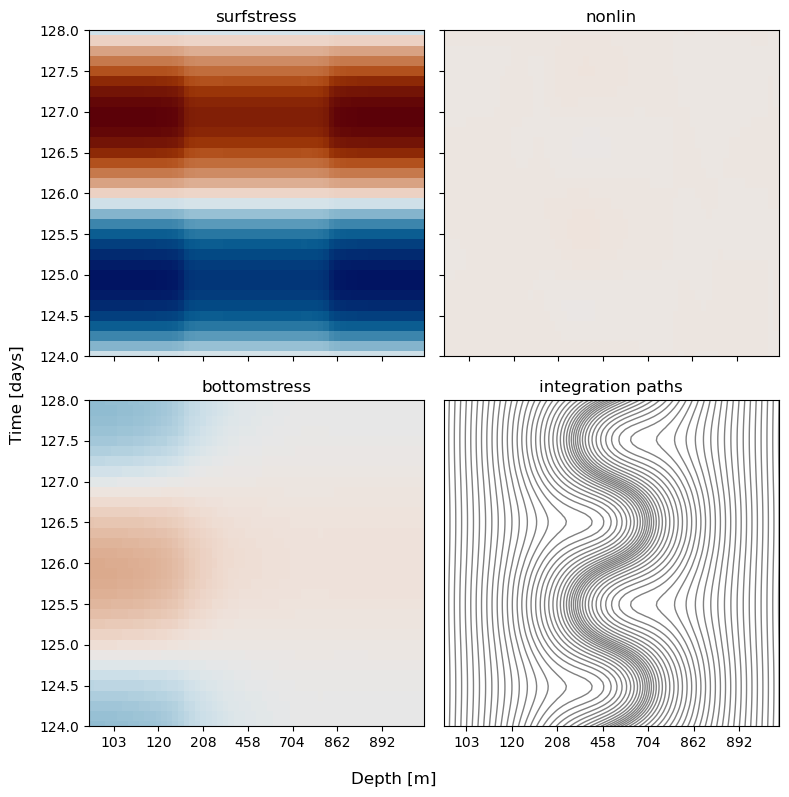

In [15]:
fig, axes = plt.subplots(figsize=(8,8), ncols=2, nrows=2, sharex=True, sharey=True)
axes = axes.flatten()

vmax = np.max([np.abs(results[term]).quantile(0.98) for term in results])

results["sum"] = results["surfstress"] + results["nonlin"] + results["bottomstress"]

terms = ["surfstress", "nonlin", "bottomstress"]
for term, ax in zip(terms, axes):
    cm = ax.pcolormesh(idxs, tday, -results[term].T, 
                  vmin=-vmax, vmax=vmax, 
                  cmap=cmc.vik)
    ax.set_title(term)


axes[-1].axis("off")

ax = fig.add_subplot(2, 2, 4)
ax.set_title("integration paths")
h = ds.h.isel(time=1).values
ax.contour(h, levels=Hs, colors="gray", linewidths=1)
ax.set_xlim(np.min(idxs), np.max(idxs))
ax.set_yticks([])

 

Td = params["T"] / (24*60*60)   
tmaxd = params["tmax"] / (24*60*60) 
#tmaxd = 64 

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(cm, cax=cbar_ax)
His = [int(H) for H in Hs]

ax.set_xticks(idxs[4::8])
ax.set_xticklabels(His[4::8])

axes[-2].set_xticks(idxs[4::8])
axes[-2].set_xticklabels(His[4::8])


axes[-2].set_ylim(tmaxd-Td, tmaxd)

fig.supxlabel("Depth [m]")
fig.supylabel("Time [days]")


fig.tight_layout()
fig.savefig(f"../figures/terms/Hcontour/Hcontour_terms_cm_{config}.png")


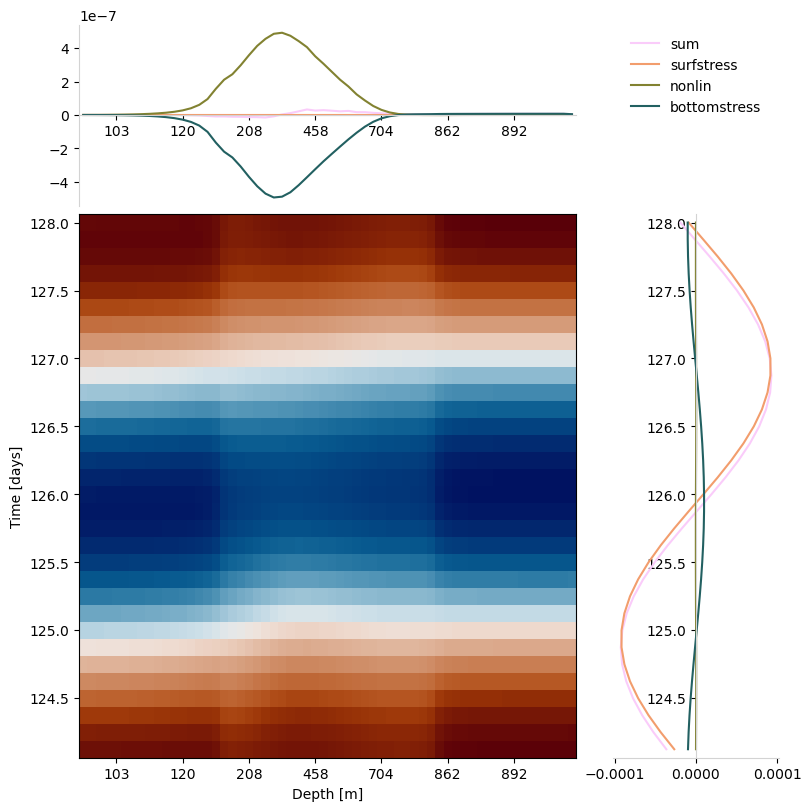

In [16]:
fig = plt.figure(layout="constrained", figsize=(8,8))
axd = fig.subplot_mosaic(
    [
        ["tmean", "legend"],
        ["circ", "xmean"],
    ],
    #empty_sentinel="BLANK",
    # set the height ratios between the rowsslice(int(tmax-T), int(tmax))
    height_ratios=[1, 3],
    # set the width ratios between the columns
    width_ratios=[3, 1]
)

cmap = cmc.batlow
n = 5
colors = [cmap(1 - i / (n - 1)) for i in range(n)]

axd["tmean"].sharex(axd["circ"])
axd["xmean"].sharey(axd["circ"])

axd["tmean"].spines['right'].set_color('none')  # Remove the right spine
axd["tmean"].spines['top'].set_color('none')  # Remove the top spine
axd["tmean"].spines['bottom'].set_position('zero')  # Set the bottom spine position
axd["tmean"].spines['left'].set_color('lightgray')
axd["tmean"].spines['bottom'].set_color('lightgray')

axd["xmean"].spines['right'].set_color('none')  # Remove the right spine
axd["xmean"].spines['top'].set_color('none')  # Remove the top spine
axd["xmean"].spines['left'].set_position('zero')  # Set the bottom spine position
axd["xmean"].spines['left'].set_color('lightgray')
axd["xmean"].spines['bottom'].set_color('lightgray')
def compute_bathymetry_gradient(X, Y, h, dx, dy):
    """Compute the gradient of the bathymetry."""
    dh_dx, dh_dy = np.gradient(h, dx, dy, edge_order=2)
    return dh_dx, dh_dy
Tn = int(params["T"]/params["outputtime"])

circT = circ.isel(time=slice(-Tn, None))
resultsT = results.isel(time=slice(-Tn, None))
vmax = np.max(np.abs(circT))
axd["circ"].pcolormesh(idxs, tday[-Tn:], circT.T, 
                  vmin=-vmax, vmax=vmax, 
                  cmap=cmc.vik)



terms = ["sum", "surfstress", "nonlin", "bottomstress"]
for term, color in zip(terms, colors):
    result = -resultsT[term]
    tmean = result.mean("time")
    
    # denne kan jeg beregne annerledes
    #xmean = result.mean("H")
    xmean = areameans[term]
    
    axd["xmean"].plot(xmean[-Tn:], tday[-Tn:], label=term, color=color)
    axd["tmean"].plot(idxs, tmean, label=term, color=color)
    
    axd["legend"].plot([None, None], [None, None], label=term,color=color)
    
    
axd["circ"].set_xlabel("Depth [m]")
axd["circ"].set_ylabel("Time [days]")

axd["circ"].set_xticks(idxs[4::8])
axd["circ"].set_xticklabels(His[4::8])

axd["tmean"].set_xticks(idxs[4::8])
axd["tmean"].set_xticklabels(His[4::8])    
    
axd["legend"].axis("off")
axd["legend"].legend(loc='upper center', 
                    frameon=False,
                )

fig.savefig(f"../figures/terms/Hcontour/Hcontour_terms_integrated_{config}.png")

: 

: 